In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.optimizers import Adam
import pyautogui

In [2]:
import pickle

In [3]:
text=""
with open('final_data.txt','r',encoding='utf-8') as f:
    text=f.read()

In [4]:
text=text.replace('\n\n',' ')
text=text.replace('\ufeff','')
text=text.split('\n')

In [5]:
#for i,sentence in enumerate(text):
#    text[i]=''.join(e for e in sentence if e!='!')

In [6]:
tokenizer=Tokenizer(filters='!"#$%&()*+-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(text)
with open('Text_pred_trained/tokenizer_test.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
input_sequences=[]
for line in text:
    token_list=tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(token_list)):
        n_gram_sequence=token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [8]:
max_sequences=max(len(x) for x in input_sequences)
input_sequences=np.array(pad_sequences(input_sequences,maxlen=max_sequences,padding='pre'))
input_sequences=input_sequences[:int(len(input_sequences)/4)]

In [9]:
xs,labels=input_sequences[:,:-1],input_sequences[:,-1]
ys=tf.keras.utils.to_categorical(labels,num_classes=len(tokenizer.word_index)+1)

In [10]:
model=keras.models.Sequential()
model.add(keras.layers.Embedding(len(tokenizer.word_index)+1,64,input_length=max_sequences-1))
model.add(keras.layers.LSTM(256,return_sequences=True))
#model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(256))
model.add(keras.layers.Dense(len(tokenizer.word_index)+1, activation='softmax'))
adam=Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 72, 64)            554560    
_________________________________________________________________
lstm (LSTM)                  (None, 72, 64)            33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 8665)              563225    
Total params: 1,183,833
Trainable params: 1,183,833
Non-trainable params: 0
_________________________________________________________________


In [14]:
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.80):
            print("Required accuracy is reached!\n")
            self.model.stop_training=True
callback=myCallbacks()

In [15]:
history=model.fit(xs,ys,epochs=100,verbose=1,callbacks=[callback])

Train on 42285 samples
Epoch 1/100
   32/42285 [..............................] - ETA: 2:05

TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [21]:
#model.save('textmodel_v5_corpus')
model.save('textmodel_test.h5')

In [16]:
import matplotlib.pyplot as plt
def plot_graph(history,string):
    plt.plot(history.history[string])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

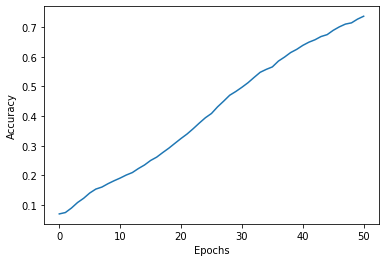

In [17]:
plot_graph(history,'accuracy')

In [ ]:
seed_text="How could you"
next_words=20
for _ in range(next_words):
    token_list=tokenizer.texts_to_sequences([seed_text])[0]
    token_list=np.array(pad_sequences([token_list],maxlen=max_sequences-1,padding='pre'))
    predicted=model.predict_classes(token_list,verbose=0)
    output_word=""
    for word,index in tokenizer.word_index.items():
        if index==predicted:
            output_word=word
            break
    seed_text+=' '+output_word
print(seed_text)

In [10]:
print(max_sequences)

73